In [6]:
import sys
!{sys.executable} -m pip install scikit-learn

  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl (8.0 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   ----------


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

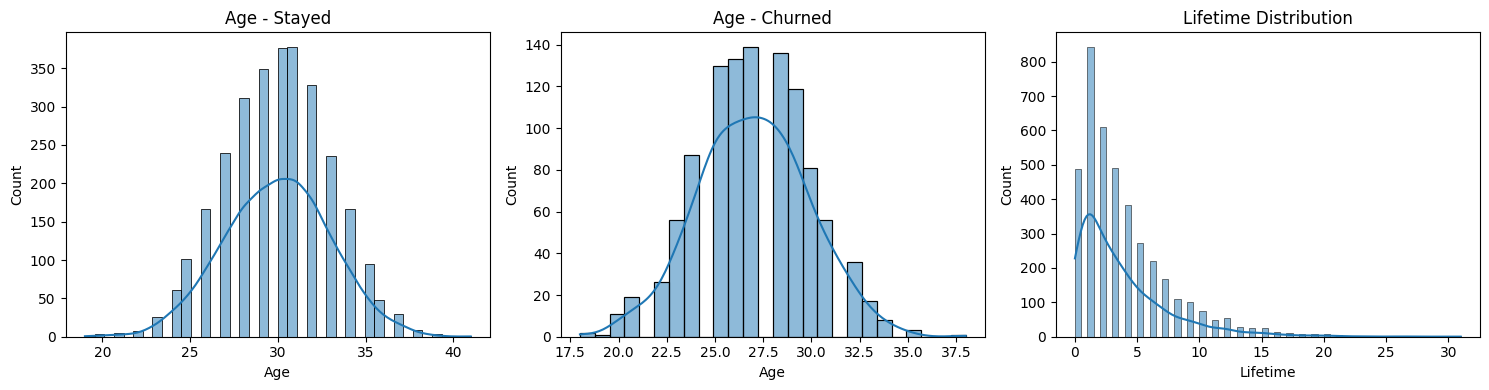

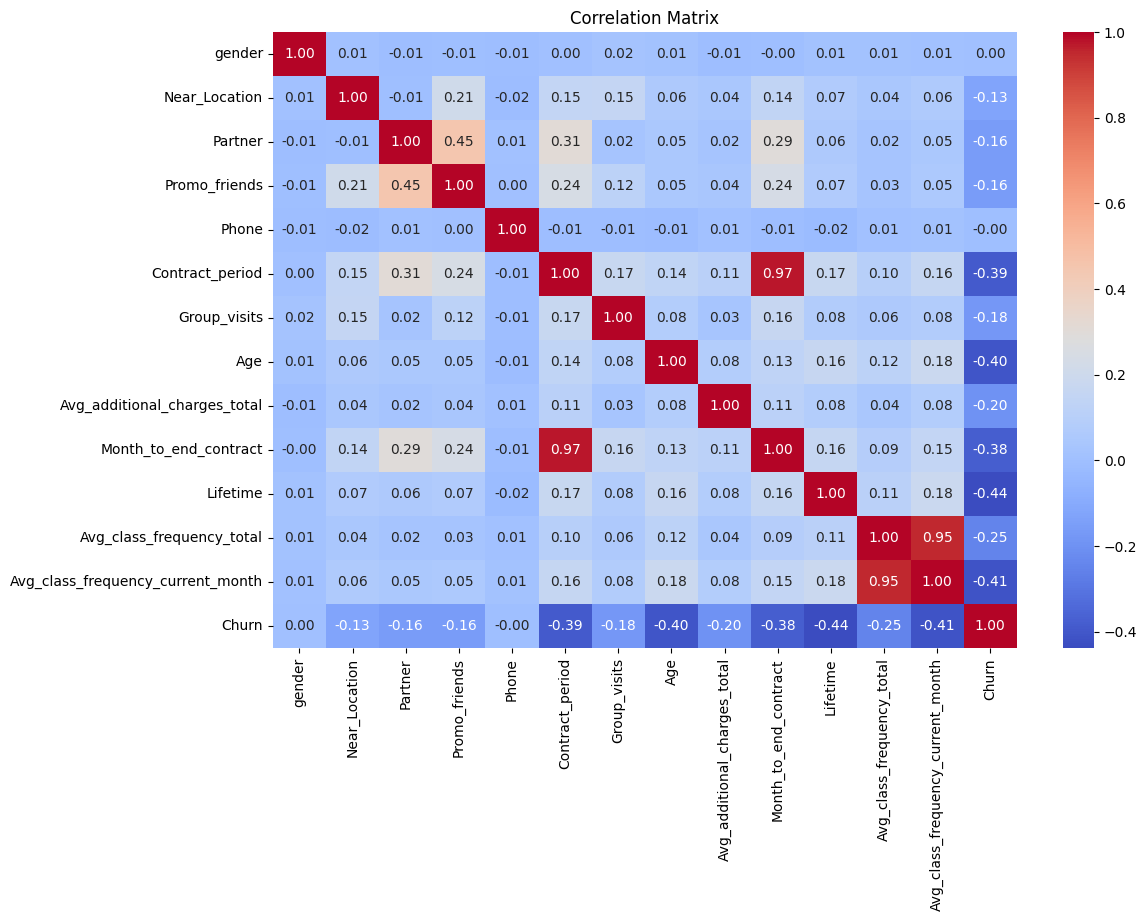

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans


# Load dataset
gym = pd.read_csv('../data/gym_churn_us.csv')

# Inspect dataset dimensions (rows, columns)
gym.shape

# Preview first rows
gym.head()

# Display dataset information (data types and non-null counts)
gym.info()

# Check for missing values
gym.isna().sum()

# Descriptive statistics summary
gym.describe()

# Compare average feature values grouped by churn status
gym.groupby('Churn').mean()


# ---------------------------------------
# Data Visualization - Distribution Analysis
# ---------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Age distribution for retained customers
sns.histplot(gym[gym['Churn'] == 0]['Age'], kde=True, ax=axes[0])
axes[0].set_title('Age - Stayed')

# Age distribution for churned customers
sns.histplot(gym[gym['Churn'] == 1]['Age'], kde=True, ax=axes[1])
axes[1].set_title('Age - Churned')

# Overall customer lifetime distribution
sns.histplot(gym['Lifetime'], kde=True, ax=axes[2])
axes[2].set_title('Lifetime Distribution')

plt.tight_layout()
plt.show()


# ---------------------------------------
# Correlation Analysis
# ---------------------------------------

plt.figure(figsize=(12, 8))

# Correlation matrix heatmap
sns.heatmap(gym.corr(), annot=True, fmt='.2f', cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()


In [13]:
# Define features (X) and target variable (y)
X = gym.drop('Churn', axis=1)
y = gym['Churn']

# Split the dataset into training and validation sets (80% / 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize numerical features (important for Logistic Regression)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# ==============================
# Model 1: Logistic Regression
# ==============================

log_model = LogisticRegression(
    random_state=42,
    max_iter=1000  # Increase iterations to ensure convergence
)

log_model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred_log = log_model.predict(X_val_scaled)

# Evaluate performance
accuracy_log = accuracy_score(y_val, y_pred_log)
precision_log = precision_score(y_val, y_pred_log)
recall_log = recall_score(y_val, y_pred_log)

accuracy_log, precision_log, recall_log


# ==============================
# Model 2: Random Forest
# ==============================

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate performance
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)

accuracy_rf, precision_rf, recall_rf

(0.91, 0.8494623655913979, 0.7821782178217822)

In [14]:
# ==============================
# Model Comparison
# ==============================

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_log, accuracy_rf],
    'Precision': [precision_log, precision_rf],
    'Recall': [recall_log, recall_rf]
})

results

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.91625,0.872928,0.782178
1,Random Forest,0.91000,0.849462,0.782178


### Model Performance Comparison

Logistic Regression achieved better overall performance compared to Random Forest.

Although both models obtained the same recall score, Logistic Regression showed higher accuracy and precision. This indicates that it classifies customers more accurately overall and produces fewer false positives when predicting churn.

Based on these results, Logistic Regression was selected as the final model for churn prediction.

In [16]:
# ==============================
# Prepare data for clustering
# ==============================

# Remove target column before clustering
gym_features = gym.drop('Churn', axis=1)

# Standardize the full dataset
scaler = StandardScaler()
gym_scaled = scaler.fit_transform(gym_features)

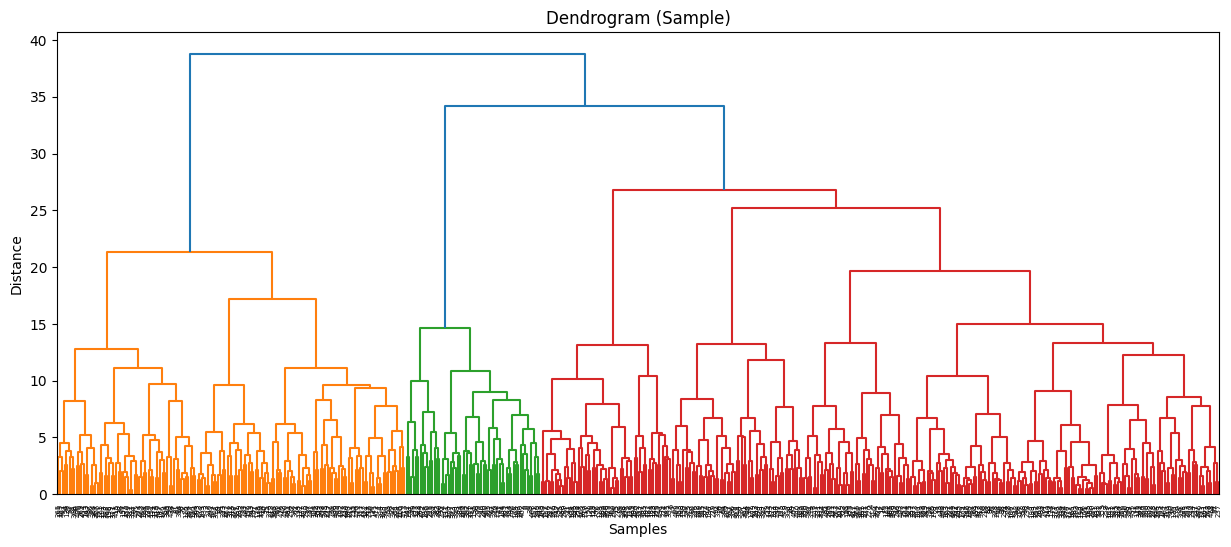

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.484801,0.698363,0.301637,0.007015,0.899454,1.733437,0.255651,28.074825,127.131782,1.657833,2.089634,1.256531,0.991781,0.587685
1,0.494471,0.947867,0.791469,0.998420,0.906793,2.740916,0.431280,28.903633,139.456908,2.540284,3.529226,1.619489,1.488508,0.285940
2,0.464396,0.913313,0.766254,0.493808,0.925697,10.495356,0.506192,30.091331,164.190347,9.484520,4.693498,2.888801,2.886027,0.013932
3,0.547794,0.937500,0.742647,0.424632,0.863971,11.194853,0.575368,29.720588,167.670439,10.347426,4.818015,1.154578,1.139605,0.042279
4,0.568233,0.878076,0.178971,0.048098,0.914989,2.120805,0.456376,29.993289,155.602830,2.013423,4.844519,2.667290,2.650122,0.105145


In [17]:
# ==============================
# Hierarchical Clustering (Dendrogram)
# ==============================

# Use a sample of the scaled dataset to improve rendering performance
gym_sample = gym_scaled[:500]

# Compute linkage matrix using Ward's method
linked = linkage(gym_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linked)
plt.title('Dendrogram (Sample)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


# ==============================
# K-Means Clustering
# ==============================

# Train K-Means model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Assign cluster labels
clusters = kmeans.fit_predict(gym_scaled)

# Add cluster labels to original dataset
gym['Cluster'] = clusters

# Analyze average feature values per cluster
gym.groupby('Cluster').mean()

### Customer Segmentation Using Clustering

To better understand customer behavior patterns, hierarchical clustering was first applied and visualized through a dendrogram. 

A sample of 500 observations was used to improve rendering performance. Based on the dendrogram structure, five clusters were selected for further segmentation analysis.

K-Means clustering (n=5) was then applied to the standardized dataset to group customers with similar behavioral and demographic characteristics.

After assigning cluster labels to each customer, the average feature values per cluster were analyzed to identify meaningful differences between segments.

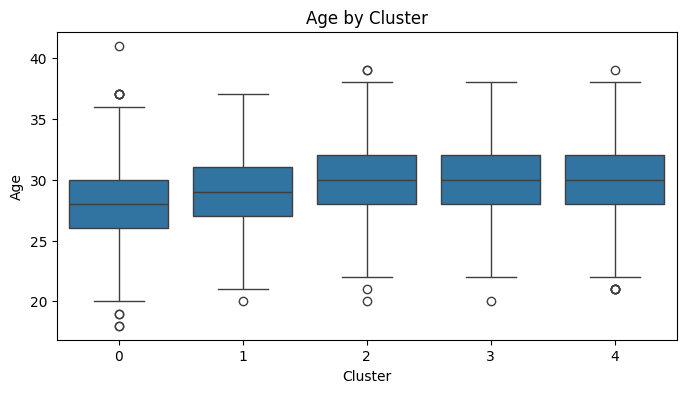

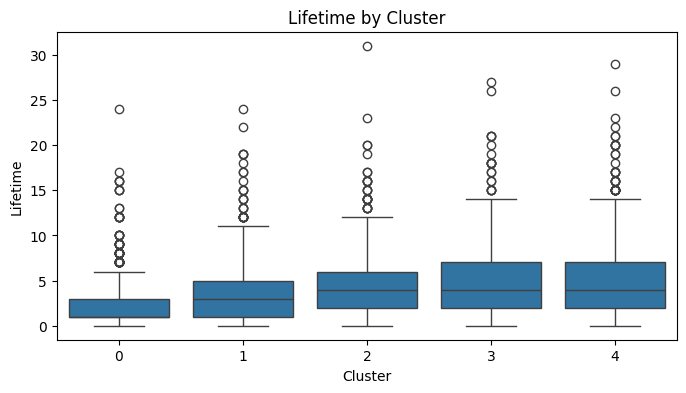

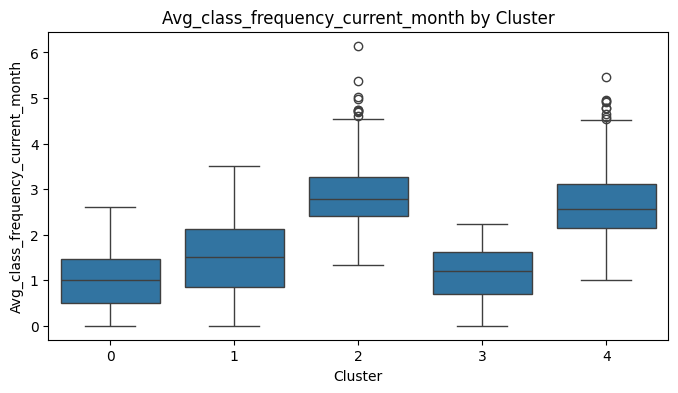

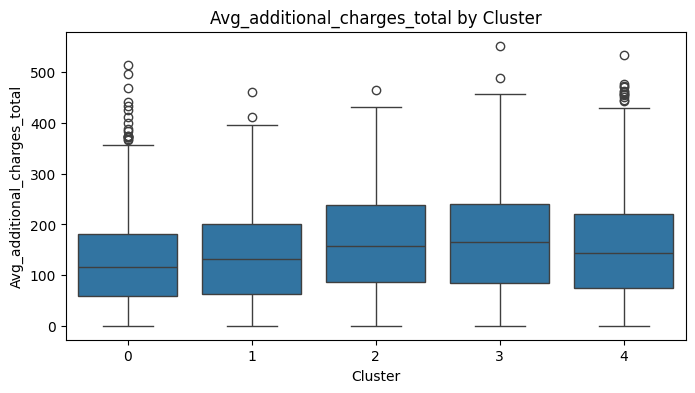

In [18]:
# ==============================
# Feature Distributions by Cluster
# ==============================

# Selected features for behavioral comparison across clusters
features = [
    'Age',
    'Lifetime',
    'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]

# Visualize distributions using boxplots
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cluster', y=feature, data=gym)
    plt.title(f'{feature} by Cluster')
    plt.show()

### Feature Distributions Across Clusters

Clear behavioral patterns can be observed across the identified clusters.

Cluster 3 stands out as the most vulnerable segment. Customers in this group show:

- The lowest lifetime (shorter membership duration)
- The lowest visit frequency
- The lowest additional spending

These characteristics strongly indicate a higher likelihood of churn.

In contrast, Clusters 1 and 2 exhibit:

- Higher visit frequency
- Longer membership duration
- Greater additional spending

These patterns suggest more engaged and loyal customers.

Age does not present significant variation across clusters, indicating that it is not a primary driver of churn in this dataset.

In [19]:
# ==============================
# Churn Rate by Cluster
# ==============================

# Calculate churn rate (mean of binary Churn variable) per cluster
# Since Churn is 0/1, the mean represents the cancellation rate
churn_by_cluster = gym.groupby('Cluster')['Churn'].mean()

churn_by_cluster

Cluster
0    0.587685
1    0.285940
2    0.013932
3    0.042279
4    0.105145
Name: Churn, dtype: float64

#### Churn Rate by Cluster – Interpretation

The churn rate clearly differs across clusters, confirming that the segmentation captures meaningful behavioral differences.

Cluster 3 stands out as the highest-risk segment, with a churn rate of approximately 57%. This group likely represents customers with low engagement and short lifetime, making them the primary target for retention strategies.

Cluster 2 is the most loyal segment, with a churn rate close to 2%, followed by Cluster 1, which also demonstrates strong retention. These customers show higher engagement and longer tenure, suggesting stable and committed members.

Clusters 0 and 4 fall into a moderate-risk category, with intermediate churn rates. These segments could benefit from proactive engagement strategies to prevent migration into higher-risk behavior.

Overall, the clustering approach successfully distinguishes between high-risk, moderate-risk, and loyal customer segments, providing actionable insight for targeted retention initiatives.

## Final Conclusion 🎯

The analysis shows that customer churn is strongly associated with **visit frequency**, **contract duration**, and **customer lifetime**, while age and gender have limited impact on cancellation behavior.  

Based on these findings, the following strategic principles are recommended to improve retention:

### 1️⃣ Focus on High-Risk Customers  
Customers with low attendance frequency, short contracts, and short tenure (such as the highest-churn cluster) should be the primary retention target.  
*Example:* early engagement campaigns during the first month, personalized reminders, and targeted reactivation offers.

### 2️⃣ Encourage Longer Contracts 📆  
Customers with longer contract durations demonstrate significantly lower churn rates.  
*Example:* early renewal discounts, exclusive benefits for 6- or 12-month contracts, and loyalty-based pricing incentives.

### 3️⃣ Promote Active Engagement 🏋️  
Higher visit frequency and usage of additional services are associated with stronger loyalty.  
*Example:* free group classes, monthly fitness challenges, and promotions for complementary services.

### 4️⃣ Retain and Reward Loyal Members ⭐  
Low-churn clusters represent stable and high-value customers. Retention efforts should reinforce their commitment.  
*Example:* loyalty programs, VIP benefits, and personalized communication to strengthen long-term relationships.

---

Overall, this analysis demonstrates that churn is primarily driven by behavioral engagement rather than demographic factors. By leveraging customer segmentation and targeted retention strategies, the gym can proactively reduce churn and increase customer lifetime value.